<div class = "alert alert-block alert-info">
    <h1><font color = "red">ATTENTION!</font></h1>
    <p>The approach is just a fun experiment, implemented in tensorflow/keras. This idea probably can generate a more meaningful modeling approach. Please consider that before looking into this code.</p>
</div>

---

**Version 4+ Update**
- Update latest TF `2.12` compatible
- **Multi-GPU** and **TPU-VM** Support

**Version 3+ Update**
- Update latest TF `2.6` compatible. 
- Fix some bugs (`steps`, `epochs`)

**Version 2 Update**

- Fix some bugs 
- Train with more epoch 

---

# About 

The idea is discussed [here, method 1](https://www.kaggle.com/c/siim-covid19-detection/discussion/245323), that is to **add an extras supervison** to the classificaiton mdoel by adding the **segmentation loss**. Basically, we make the use of the bounding box information to crop the anomaly region from the chest x-ray samples and further use those cropped samples as an additional targets for the classifier model at **cetain layer**. Here is the general overview of this approach. 

![Untitled-2](https://user-images.githubusercontent.com/17668390/122642346-dc044b80-d12b-11eb-9cb9-d1771a682541.png)

<div align="center">
  Figure 1: Cropped ROI Segment for the Additional Supervision to the Classifier.
</div>

For input image of shape `512`, we will get `16` dimention of `n` depth feature maps at the last layer of base model. As the segmentation target would be one channel and downsampled to match last layer feature maps, we need to add a simple **mask head**. 

In [1]:
import os, math, warnings
import psutil, random 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import cv2; print(cv2.__version__)
import tensorflow as tf; print(tf.__version__)
from tensorflow import keras
from tensorflow.python.client import device_lib

4.5.4
2.11.0


In [2]:
def set_tpu(mixed_precision=True):
    try: 
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() 
        
        if mixed_precision:
            keras.mixed_precision.set_global_policy(
                "mixed_bfloat16"
            )
        else:
            keras.mixed_precision.set_global_policy(
                keras.backend.floatx()
            )
            
        tf.config.set_soft_device_placement(True)
        strategy = tf.distribute.TPUStrategy(tpu)
        physical_devices = tf.config.list_logical_devices('TPU')
        return (strategy, physical_devices)
    except:
        return False

In [3]:
def set_cpu_gpus(mixed_precision=True, set_jit=False):
    try: 
        # printed out the detected devices
        list_ld = device_lib.list_local_devices()
        for dev in list_ld: 
            print(dev.name,dev.memory_limit)
        
        # get the lisf of physical devices
        physical_devices = tf.config.list_physical_devices(
            'GPU' if len(list_ld) - 1 else 'CPU'
        )
        
        # For GPU devices, configure related stuff
        if 'GPU' in physical_devices[-1]:
            tf.config.optimizer.set_jit(set_jit)
            
            if mixed_precision:
                keras.mixed_precision.set_global_policy(
                    "mixed_float16"
                )
            else:
                keras.mixed_precision.set_global_policy(
                    keras.backend.floatx()
                )
                
            for pd in physical_devices:
                tf.config.experimental.set_memory_growth(
                    pd, True
                )
                
        strategy = tf.distribute.MirroredStrategy()
        return (strategy, physical_devices)
    except: 
        raise ValueError('No Device Detected!')

In [4]:
mxp = True
jit = True

strategy, physical_devices = set_tpu(mixed_precision=mxp) or set_cpu_gpus(mixed_precision=mxp, set_jit=jit)
physical_devices, tf.__version__

/device:CPU:0 268435456
/device:GPU:0 14400880640
/device:GPU:1 14400880640


([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
  PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')],
 '2.11.0')

# Data Preprocess

Here is the quick data pre-process to make the data suitable for the training data. For extensive data data analysis, please refer to the following scripts.

- [SIIM Covid-19: Box Detect & .dcm metadata](https://www.kaggle.com/andradaolteanu/siim-covid-19-box-detect-dcm-metadata)
- [SIIM COVID-19 Detection: EDA + Data Augmentation](https://www.kaggle.com/ruchi798/siim-covid-19-detection-eda-data-augmentation)

In [5]:
study_df = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv'); print(study_df.shape)
study_df['StudyInstanceUID'] = study_df['id'].apply(lambda x: x.replace('_study', ''))
del study_df['id']

def hot_to_sparse(row):
    return(row.index[row.apply(lambda x: x==1)][0])
study_df['diagnosis'] = study_df.apply(lambda row:hot_to_sparse(row), axis=1)
cls = {
    'Typical Appearance':1,                    
    'Negative for Pneumonia':2,                
    'Indeterminate Appearance':3,                     
    'Atypical Appearance':4,    
}
study_df['sparse_gt'] = study_df.diagnosis.map(cls) 

image_df = pd.read_csv('../input/siim-covid19-detection/train_image_level.csv'); print(image_df.shape)
train = image_df.merge(study_df, on='StudyInstanceUID')
train['id'] = train['id'].apply(lambda x: x.replace('_image', ''))
display(train.head()); print(train.shape)

(6054, 5)
(6334, 4)


,id,boxes,label,StudyInstanceUID,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,diagnosis,sparse_gt
0,000a312787f2,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,0,1,0,0,Typical Appearance,1
1,000c3a3f293f,NaN,none 1 0 0 1 1,ff0879eb20ed,1,0,0,0,Negative for Pneumonia,2
2,0012ff7358bc,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,0,1,0,0,Typical Appearance,1
3,001398f4ff4f,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,0,0,0,1,Atypical Appearance,4
4,001bd15d1891,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,0,1,0,0,Typical Appearance,1


(6334, 10)


# ROI Segment: Cropped Bounding Box

In [6]:
def vis(path1, path2, n_images, is_random=True, figsize=(16, 16)):
    '''
    https://gist.github.com/innat/00de7561033ba373745d425c6da7bf8c
    '''
    image_names = os.listdir(path1)
    masks_names = os.listdir(path2)
    
    for i in range(n_images):
        if is_random:
            image_name = random.choice(masks_names)
            masks_name = image_name
        else:
            image_name = masks_names[i]
            masks_name = masks_names[i]
            
        img = cv2.resize(cv2.imread(os.path.join(path1, image_name)), (512, 512))
        msk = cv2.resize(cv2.imread(os.path.join(path2, masks_name)), (512, 512))
        
        plt.figure(figsize=(20,20))
        plt.subplot(121); plt.imshow(img);
        plt.subplot(122); plt.imshow(msk);
        plt.show()

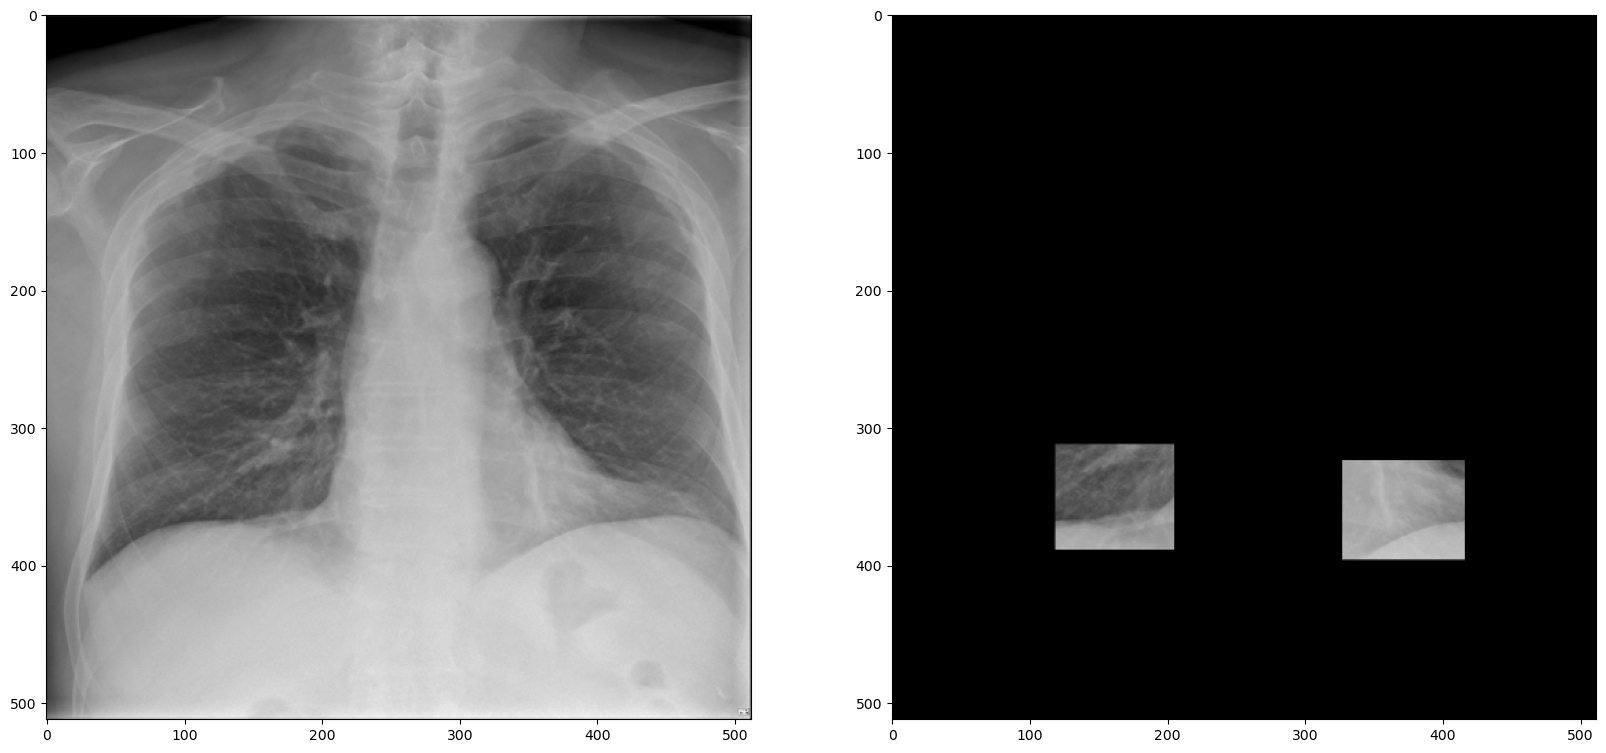

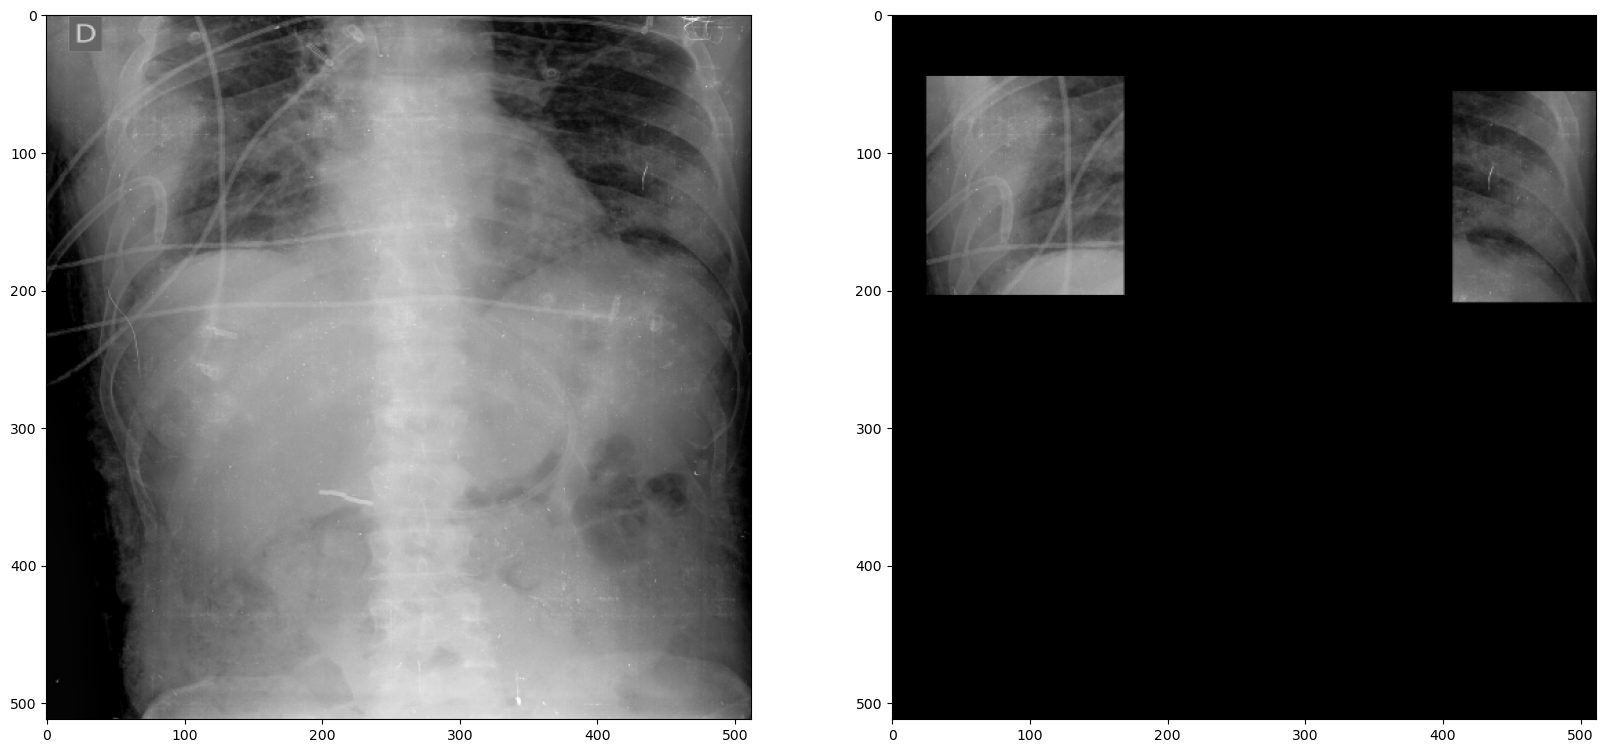

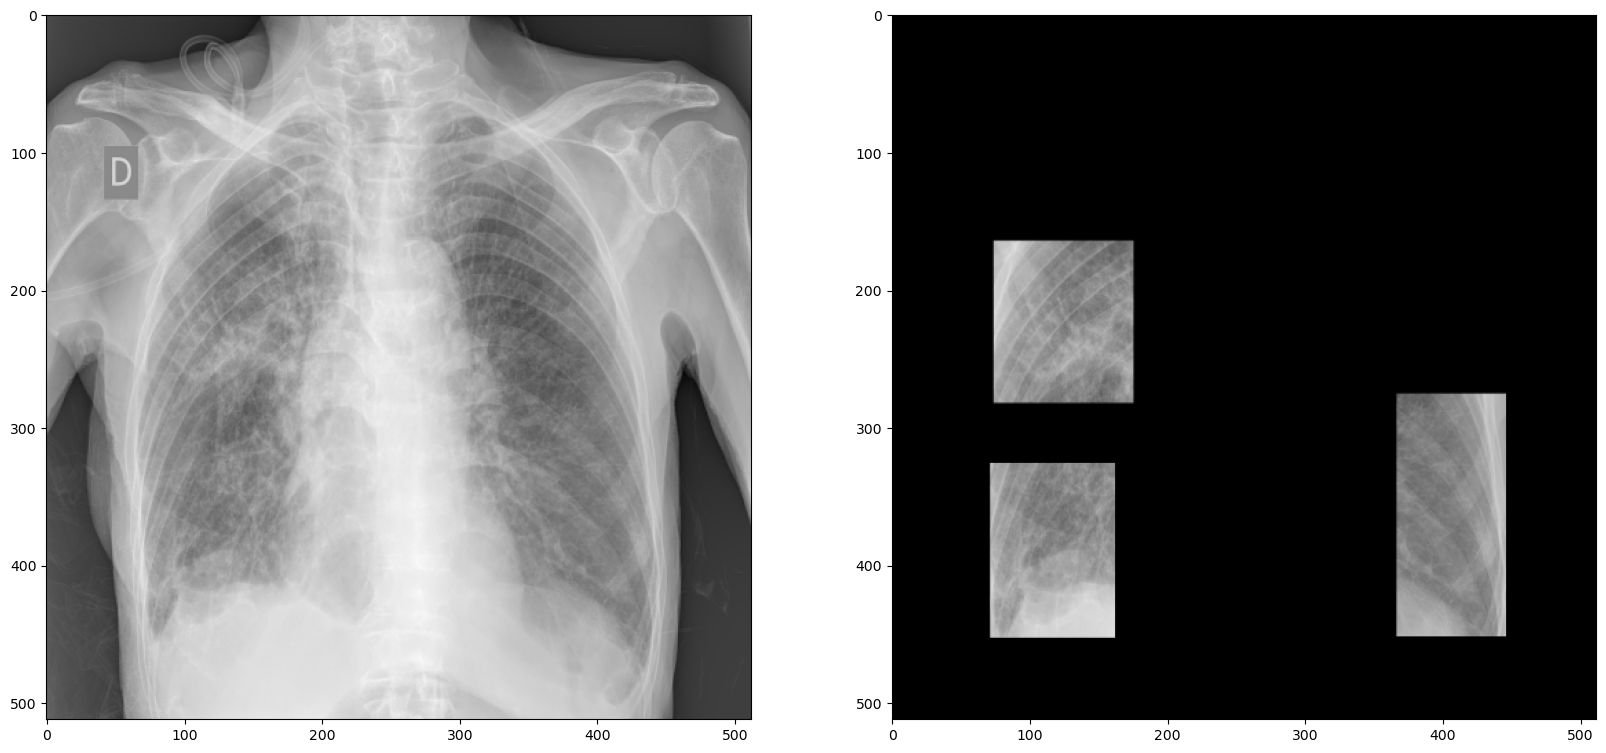

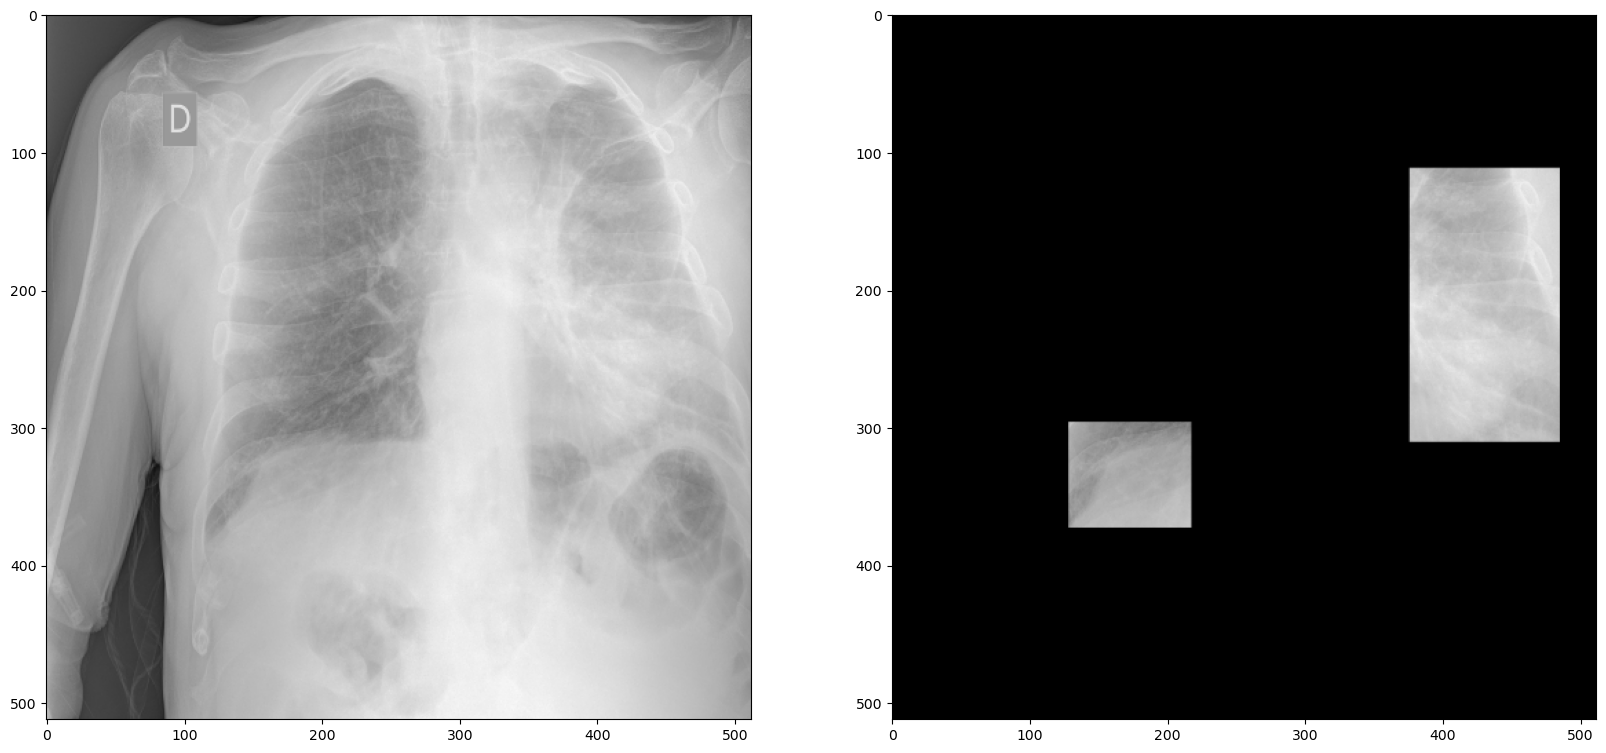

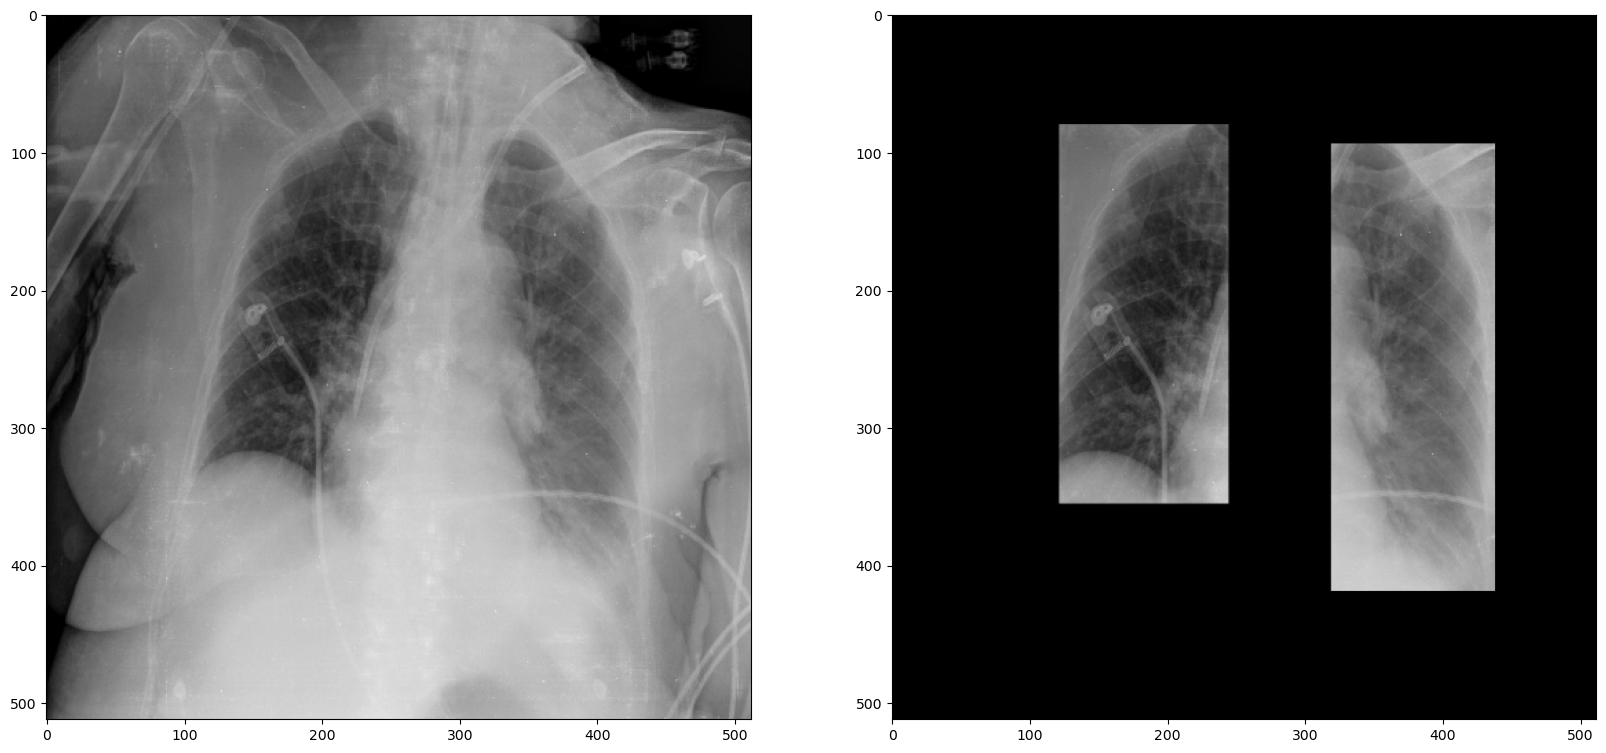

In [7]:
base_path = '../input/covid19-detection-890pxpng-study'
TRAIN_IMG_PATH =  os.path.join(base_path, 'train/')
TRAIN_MSK_PATH = os.path.join(base_path, 'ROI Mask/')
vis(TRAIN_IMG_PATH, TRAIN_MSK_PATH, 5, is_random=True)

In [8]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)
for index, (train_index, val_index) in enumerate(
    skf.split(X=train.index, y=train.sparse_gt)
):
    train.loc[val_index, 'fold'] = index
    
print(train.groupby(['fold', train.sparse_gt]).size())

fold  sparse_gt
0.0   1            602
      2            347
      3            221
      4             97
1.0   1            602
      2            347
      3            222
      4             96
2.0   1            601
      2            348
      3            222
      4             96
3.0   1            601
      2            347
      3            222
      4             97
4.0   1            601
      2            347
      3            221
      4             97
dtype: int64


# Covid-19 `Keras-Sequence` Data Generator

In [9]:
import albumentations as A 

# For Validation 
def albu_transforms_train(data_resize): 
    return A.Compose([
        A.Resize(data_resize, data_resize)
        # Can be added more augmentation ... 
    ], p=1.)


# For Validation 
def albu_transforms_valid(data_resize): 
    return A.Compose([
        A.Resize(data_resize, data_resize)
    ], p=1.)

In [10]:
class Covid19Generator(keras.utils.Sequence):
    def __init__(
        self, 
        img_path, 
        msk_path, 
        data, 
        batch_size, 
        random_state, 
        idim, mdim, 
        shuffle=True, 
        transform=None, 
        is_train=False
    ):
        self.idim = idim
        self.mdim = mdim  
        self.data = data
        self.shuffle = shuffle
        self.img_path = img_path
        self.msk_path = msk_path
        self.is_train = is_train
        self.augment  = transform
        self.batch_size = batch_size
        self.random_state = random_state
        self.list_idx = data.index.values
        self.label = self.data[
            [
                'Negative for Pneumonia', 'Typical Appearance', 
                'Indeterminate Appearance', 'Atypical Appearance']
        ] if self.is_train else np.nan
        self.on_epoch_end()
        
    def __len__(self):
        batch_len = int(np.floor(len(self.list_idx) / self.batch_size))
        if batch_len*self.batch_size < len(self.data):
            batch_len += 1
        return batch_len
    
    def __getitem__(self, index):
        batch_idx = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        idx = [self.list_idx[k] for k in batch_idx]
        
        Data = np.zeros((self.batch_size,) + self.idim + (3,), dtype="float32")
        Mask = np.zeros((self.batch_size,) + self.mdim + (1,), dtype="float32")
        Target = np.zeros((self.batch_size, 4), dtype = np.float32)

        for i, k in enumerate(idx):
            # load the image file using cv2
            image = cv2.imread(self.img_path + self.data['id'][k] + '.png')[:, :, [2, 1, 0]]
            mask = cv2.imread(self.msk_path + self.data['id'][k] + '.png', 0)
            
            try:
                mask = cv2.resize(mask, self.mdim)[:, :, np.newaxis]
            except:
                mask = np.zeros_like(cv2.resize(image[:,:,:1], self.mdim))[:, :, np.newaxis]
          
            res = self.augment(image=image)
            image = res['image']
            
            # mask normalization must
            mask = np.where(mask == 0, 0, 1)
            # mask = mask.astype(np.float32)/255.0 

            # assign 
            if self.is_train:
                Data[i,] = image
                Mask[i,] = mask
                Target[i,] = self.label.iloc[k,].values 
            else:
                Data[i,] =  image 
        
        inps = {'input': Data}
        outs = {'clss': Target, 'segg': Mask}
        return inps, outs
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.list_idx))
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indices)

**Viz**

In [11]:
import matplotlib.pyplot as plt 
from pylab import rcParams

# helper function to plot sample 
def plot_imgs(dataset_show, row, col):
    rcParams['figure.figsize'] = 20,10
    for i in range(row):
        f, ax = plt.subplots(1,col)
        for p in range(col):
            idx = np.random.randint(0, len(dataset_show))
            img, label = dataset_show[idx]
            ax[p].grid(False)
            ax[p].imshow(label['segg'][0], cmap='gray')
            ax[p].set_title(label['clss'][0])
    plt.show()

In [12]:
fold = 0
img_size   = 512
msk_sizze  = 16
batch_size = 32 * strategy.num_replicas_in_sync

In [13]:
def fold_generator(fold):
    # for way one - data generator
    train_labels = train[train.fold != fold].reset_index(drop=True)
    val_labels = train[train.fold == fold].reset_index(drop=True)

    train_generator = Covid19Generator(
        TRAIN_IMG_PATH, TRAIN_MSK_PATH,
        train_labels, 
        batch_size, 
        1234, 
        (img_size, img_size), 
        (msk_sizze, msk_sizze),
        shuffle = True, 
        is_train = True,
        transform = albu_transforms_train(img_size)
    )
    
    val_generator = Covid19Generator(
        TRAIN_IMG_PATH, TRAIN_MSK_PATH,
        val_labels, 
        batch_size, 
        1234, 
        (img_size, img_size), 
        (msk_sizze, msk_sizze),
        shuffle = False, 
        is_train = True,
        transform = albu_transforms_valid(img_size)
    )

    return train_generator, val_generator, train_labels, val_labels


# first fold 
train_gen, val_gen, train_len, val_len = fold_generator(fold)

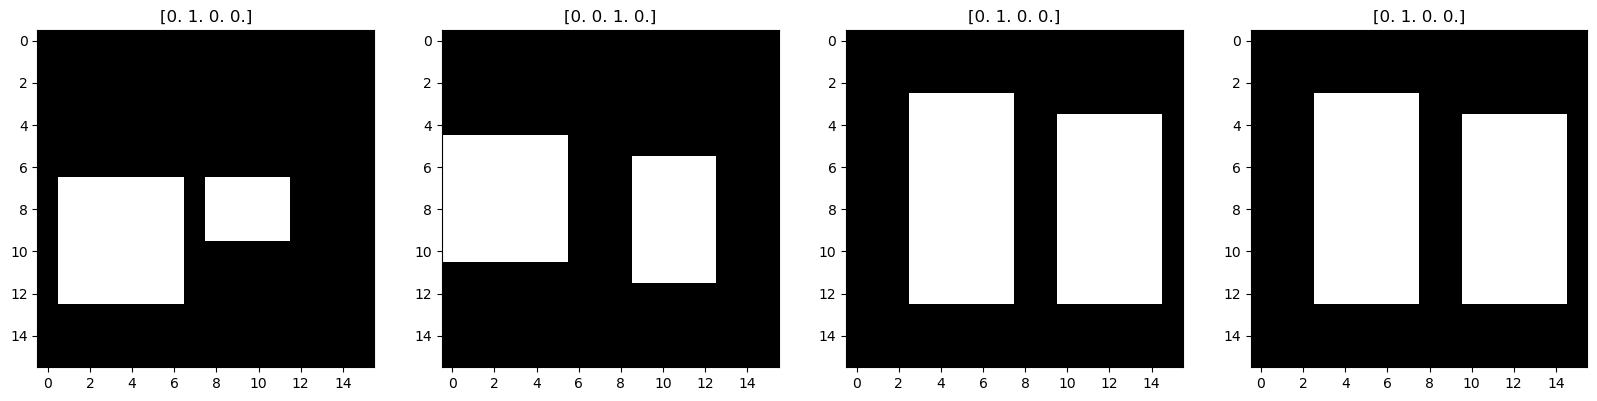

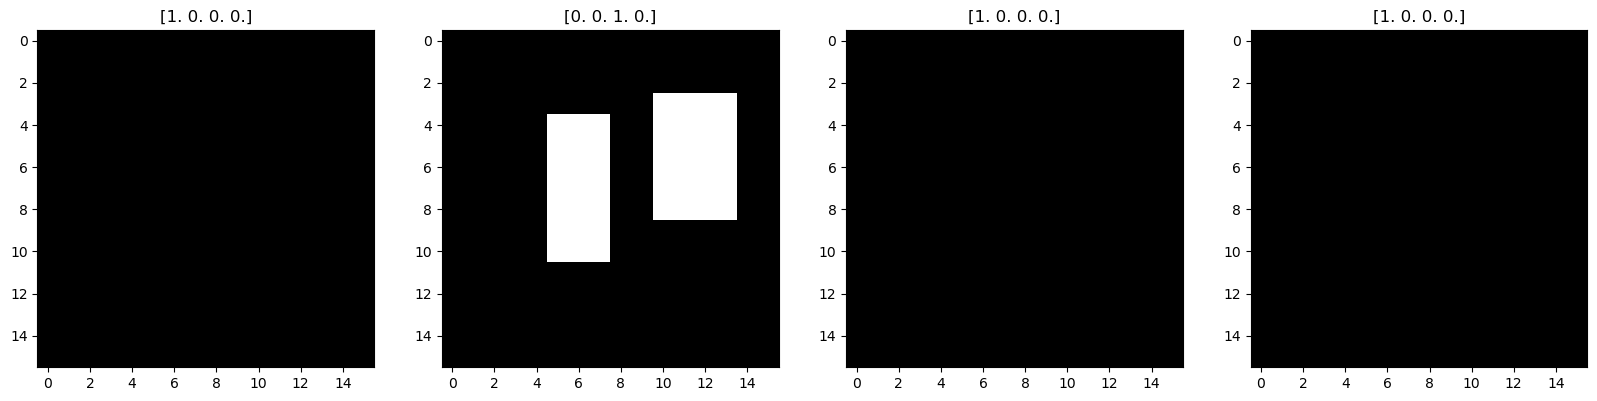

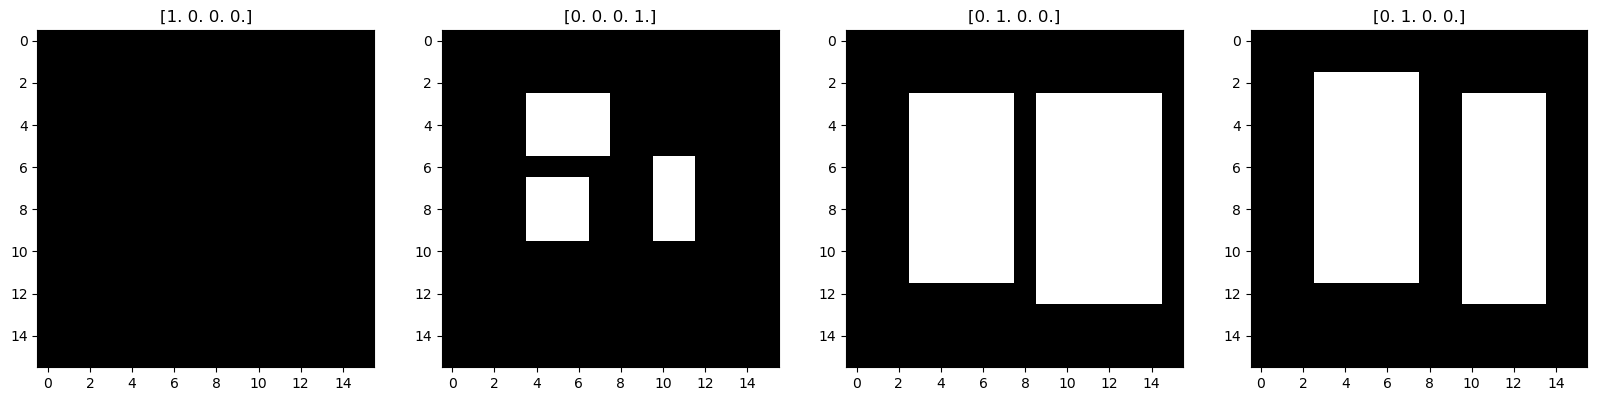

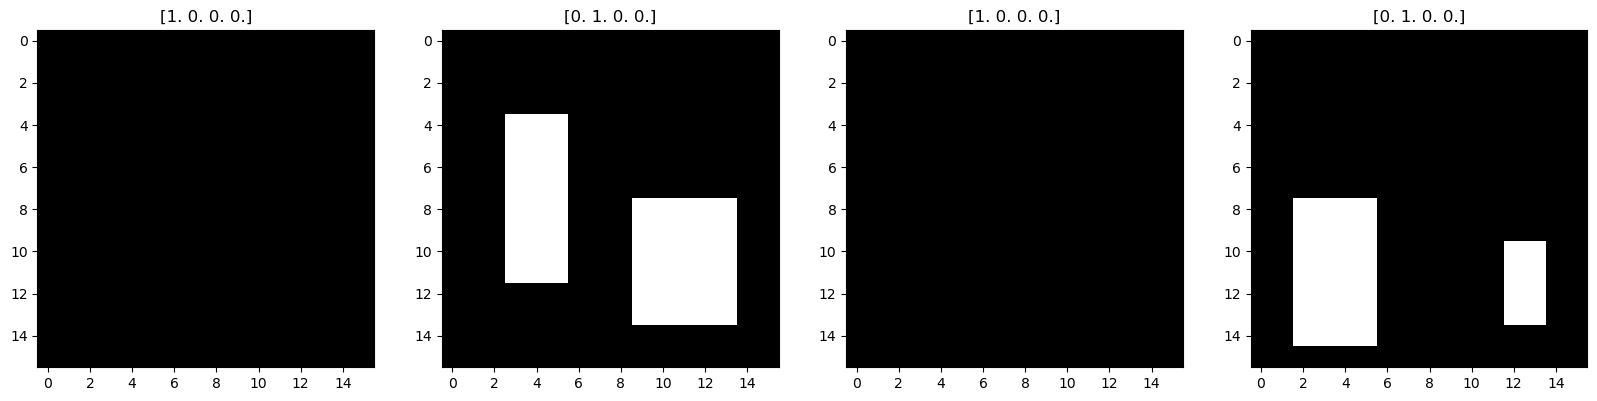

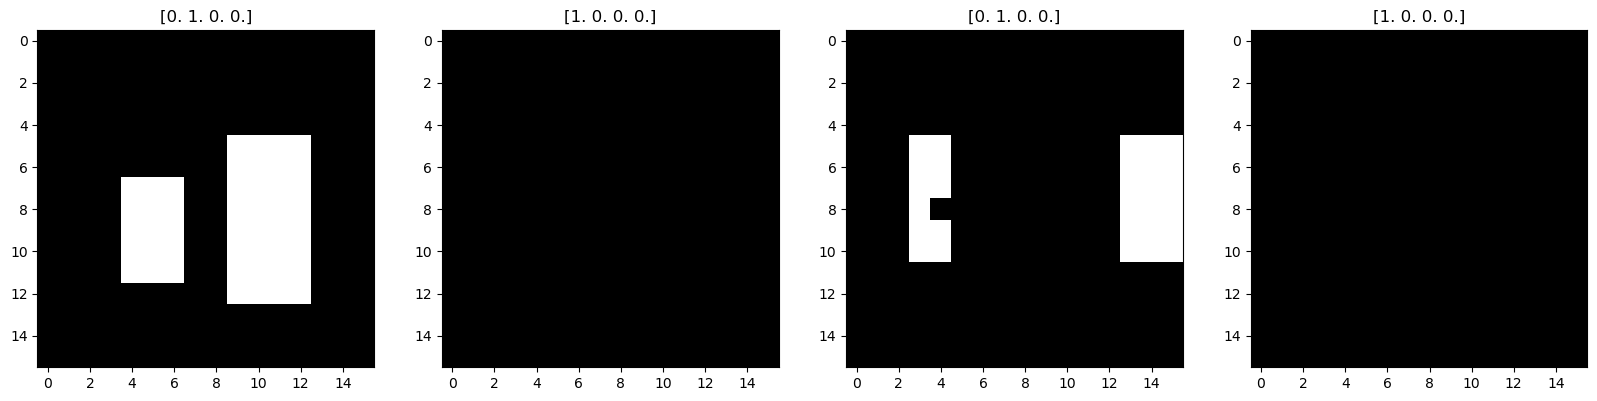

In [14]:
plot_imgs(train_gen, 5, 4) # plotting only 16x mask

# Model 

For demonstration purpose, we pick `EfficientNet` model with image shape `512 x 512`. And for segmentation prediction maps, we will pick layer `top_activation` and pass it to **maks head** branch further processsing. 

```python
for layer in applications.EfficientNetB1(input_shape=(512, 512, 3), weights=None).layers[-10:]:
    print(layer.name, layer.output_shape)
    
[out]:
block7b_project_conv (None, 16, 16, 320)
block7b_project_bn (None, 16, 16, 320)
block7b_drop (None, 16, 16, 320)
block7b_add (None, 16, 16, 320)
top_conv (None, 16, 16, 1280)
top_bn (None, 16, 16, 1280)
top_activation (None, 16, 16, 1280)

# moved out for top free
avg_pool (None, 1280)
top_dropout (None, 1280)
predictions (None, 1000)
```

In [15]:
from tensorflow.keras import Model 
from tensorflow.keras import Sequential 
from tensorflow.keras import Input 
from tensorflow.keras import layers 
from tensorflow.keras import applications 

class CovidNet(Model):
    def __init__(self):
        super(CovidNet, self).__init__()
        self.base = applications.EfficientNetB1(
            input_shape=(512, 512, 3),
            include_top=False,
            weights='imagenet'
        )
        
        # desired model 
        self.base = Model(
                [self.base.inputs], 
                [
                    self.base.get_layer('top_activation').output, 
                    self.base.output
                ]
            )
        
        # tail / head for the classifier 
        self.tail = Sequential(
            [
                layers.GlobalAveragePooling2D(),
                layers.Dropout(0.2),
                layers.BatchNormalization(),
                layers.Dense(4),
                layers.Softmax()
            ]
        )
        
        # tail / head for the mask 
        self.msk = Sequential(
            [
                layers.Conv2D(
                    filters=512, 
                    kernel_size=(1, 1), 
                    strides=(1, 1), 
                    padding="same"
                ),
                layers.ReLU(),
                layers.BatchNormalization(),
                layers.Conv2D(filters=1, kernel_size=(1,1), padding="same")
            ]
        )

    # feed-forwarding  
    def call(self, inputs, training=None, **kwargs):
        segg, clss = self.base(inputs['input'])

        return {
            'clss': self.tail(clss), 
            'segg': self.msk(segg)
        }
    

with strategy.scope():
    model = CovidNet()
    model.build(input_shape={'input': (None, 512, 512, 3)})
model.summary()

27018416/27018416 [==============================] - 0s 0us/step
Model: "covid_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          [(None, 16, 16, 1280),    6575239   
                              (None, 16, 16, 1280)]              
                                                                 
 sequential (Sequential)     (None, 4)                 10244     
                                                                 
 sequential_1 (Sequential)   (None, 16, 16, 1)         658433    
                                                                 
Total params: 7,243,916
Trainable params: 7,178,277
Non-trainable params: 65,639
_________________________________________________________________


# Training

In [16]:
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules
from tensorflow.keras.optimizers.schedules import LearningRateSchedule, ExponentialDecay

class WarmupLearningRateSchedule(LearningRateSchedule):
    """Provides a variety of learning rate decay schedules with warm up."""

    def __init__(
        self,
        initial_lr,
        steps_per_epoch=None,
        lr_decay_type='exponential',
        decay_factor=0.97,
        decay_epochs=2.4,
        total_steps=None,
        warmup_epochs=5,
        minimal_lr=0
    ):
        super(WarmupLearningRateSchedule, self).__init__()
        self.initial_lr = initial_lr
        self.steps_per_epoch = steps_per_epoch
        self.lr_decay_type = lr_decay_type
        self.decay_factor = decay_factor
        self.decay_epochs = decay_epochs
        self.total_steps = total_steps
        self.warmup_epochs = warmup_epochs
        self.minimal_lr = minimal_lr

    def __call__(self, step):
        if self.lr_decay_type == 'exponential':
            assert self.steps_per_epoch is not None
            decay_steps = self.steps_per_epoch * self.decay_epochs
            lr = ExponentialDecay(
                self.initial_lr, 
                decay_steps, 
                self.decay_factor, staircase=True
            )(step)
        elif self.lr_decay_type == 'cosine':
            assert self.total_steps is not None
            lr = 0.5 * self.initial_lr * (
              1 + tf.cos(np.pi * tf.cast(step, tf.float32) / self.total_steps))
            
        elif self.lr_decay_type == 'linear':
            assert self.total_steps is not None
            lr = (1.0 - tf.cast(step, tf.float32) / self.total_steps) * self.initial_lr
        elif self.lr_decay_type == 'constant':
            lr = self.initial_lr
        else:
            assert False, 'Unknown lr_decay_type : %s' % self.lr_decay_type

        if self.minimal_lr:
            lr = tf.math.maximum(lr, self.minimal_lr)

        if self.warmup_epochs:
            warmup_steps = int(self.warmup_epochs * self.steps_per_epoch)
            warmup_lr = (
              self.initial_lr * tf.cast(step, tf.float32) /
              tf.cast(warmup_steps, tf.float32))
            lr = tf.cond(step < warmup_steps, lambda: warmup_lr, lambda: lr)

        return lr

    def get_config(self):
        return {
            'initial_lr': self.initial_lr,
            'steps_per_epoch': self.steps_per_epoch,
            'lr_decay_type': self.lr_decay_type,
            'decay_factor': self.decay_factor,
            'decay_epochs': self.decay_epochs,
            'total_steps': self.total_steps,
            'warmup_epochs': self.warmup_epochs,
            'minimal_lr': self.minimal_lr,
        }

In [17]:
steps_per_epoch  = np.ceil(float(len(train_len)) / batch_size) 
validation_steps = np.ceil(float(len(val_gen)) / batch_size) 
epochs = 20

lr_sched = 'cosine'
lr_base = 0.016
lr_min=0
lr_decay_epoch = 2.4
lr_warmup_epoch = 5
lr_decay_factor = 0.97

scaled_lr = lr_base * (batch_size / 256.0)
scaled_lr_min = lr_min * (batch_size / 256.0)
total_steps = steps_per_epoch * epochs

learning_rate = WarmupLearningRateSchedule(
    scaled_lr,
    steps_per_epoch=steps_per_epoch,
    decay_epochs=lr_decay_epoch,
    warmup_epochs=lr_warmup_epoch,
    decay_factor=lr_decay_factor,
    lr_decay_type=lr_sched,
    total_steps=total_steps,
    minimal_lr=scaled_lr_min
)

# Compile and Run 

In [18]:
from tensorflow.keras import losses 
from tensorflow.keras import metrics
from tensorflow.keras import optimizers

with strategy.scope():
    # bind all
    model.compile(
        loss = {
            'clss': losses.CategoricalCrossentropy(
                label_smoothing=0, from_logits=False
            ),
            'segg': losses.BinaryCrossentropy(
                from_logits=True
            )
        },

        metrics = {
            'clss': [
                metrics.AUC(curve='ROC'),
                metrics.SpecificityAtSensitivity(0.70, name='@sensitivity')
            ]
        },

        optimizer = optimizers.Adam(learning_rate)
    )

In [19]:
# list of call backs 
from tensorflow.keras import callbacks

callback_list = [
       callbacks.ModelCheckpoint(
            filepath='model.{epoch:02d}-{val_loss:.4f}.h5', 
            save_freq='epoch', 
            verbose=0, 
            monitor='val_loss', 
            save_weights_only=True, 
            save_best_only=True
       )         
]

In [20]:
# fitter 
model.fit(
    train_gen, 
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_data=val_gen, 
    callbacks=callback_list, 
    workers=psutil.cpu_count() - 1, 
    verbose=1,
    epochs=epochs
)

Epoch 1/20
80/80 [==============================] - 590s 5s/step - loss: 2.0204 - clss_loss: 1.3866 - segg_loss: 0.6339 - clss_auc: 0.7172 - clss_@sensitivity: 0.5959 - val_loss: 1.4419 - val_clss_loss: 1.0227 - val_segg_loss: 0.4189 - val_clss_auc: 0.8309 - val_clss_@sensitivity: 0.7292
Epoch 2/20
80/80 [==============================] - 246s 3s/step - loss: 1.3512 - clss_loss: 1.0602 - segg_loss: 0.2910 - clss_auc: 0.8252 - clss_@sensitivity: 0.8032 - val_loss: 7.3535 - val_clss_loss: 7.0918 - val_segg_loss: 0.2607 - val_clss_auc: 0.7346 - val_clss_@sensitivity: 0.7292
Epoch 3/20
80/80 [==============================] - 231s 3s/step - loss: 1.2996 - clss_loss: 1.0774 - segg_loss: 0.2222 - clss_auc: 0.8194 - clss_@sensitivity: 0.7868 - val_loss: 14.8945 - val_clss_loss: 14.3555 - val_segg_loss: 0.5393 - val_clss_auc: 0.5245 - val_clss_@sensitivity: 0.0000e+00
Epoch 4/20
80/80 [==============================] - 231s 3s/step - loss: 1.4550 - clss_loss: 1.2208 - segg_loss: 0.2341 - clss_

# Resources 
- [Mask Spatial Supervision](https://www.kaggle.com/ipythonx/blending-mask-with-x-ray-for-spatial-supervision/notebook?scriptVersionId=66218468): Try to experiemnt by blending with bounding box mask information, (method 1 + method 2).
- [Add Attention Mechansim](https://www.kaggle.com/ipythonx/tf-keras-ranzcr-multi-attention-efficientnet): Try to add attention function to build hybrid model. 
- [Out-of-Fold Evaluation](https://www.kaggle.com/ipythonx/optimizing-metrics-out-of-fold-weights-ensemble): Compute the oof each fold and compare the match and non-match prediction in order to emphasize on the weak or minor cases. 